## Import libraries

In [1]:
import os
os.getcwd()
# Degree, centrality 등 저장하는 부분 추가해야함.

'/Users/jeonjunhwi/문서/Projects/Master_GNN/Code'

In [2]:
from stgraph_trainer.datasets import load_province_temporal_data
from stgraph_trainer.datasets import load_province_coordinates
from stgraph_trainer.datasets import preprocess_data_for_stgnn
from stgraph_trainer.utils import PairDataset
from stgraph_trainer.utils import compute_metrics
from stgraph_trainer.utils import matplotlib_plot_font
from stgraph_trainer.utils import save_figure_predict
from torch.utils.data import DataLoader
from stgraph_trainer.models import ProposedSTGNN
from stgraph_trainer.trainers import ProposedSTGNNTrainer
import torch
import numpy as np
import pandas as pd
import dgl
import scipy.sparse as sp

torch.manual_seed(42)
matplotlib_plot_font()

/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using TensorFlow backend.


## Load and process dataset
### Setup parameters

In [3]:
MODEL_NAME = "STGNN"
TIME_STEPS = 5
BATCH_SIZE = 16
EPOCHS = 100
learning_rate = 1e-3
device = torch.device('cuda', 0) if torch.cuda.is_available() else torch.device('cpu')

### Temporal data

In [4]:
region_type = 'state'
df = pd.read_csv(f'/Users/jeonjunhwi/문서/Projects/Master_GNN/Data/KCDC_data/Processing_Results/smoothing_3_{region_type}_mean.csv', index_col=0, encoding='cp949')
df = df.iloc[100:700] # 12월 까지만 해보자

# region_dict = {}
# for i, region in enumerate(df.columns):
#     region_dict[i] = region
    
# len_val = int(df.shape[0] * 0.2)
# len_test = 14
# len_train = df.shape[0] - len_val - len_test

# train, val, test, _, _, scaler = preprocess_data_for_stgnn(data=df,
#                                                            len_train=len_train,
#                                                            len_val=len_val,
#                                                            len_test=len_test,
#                                                            time_steps=TIME_STEPS)
region_dict = {}
for i, region in enumerate(df.columns):
    region_dict[i] = region 
    
split_date = '2021-11-29'
val_ratio = 0.2

train, val, test, _, _, scaler = preprocess_data_for_stgnn(data = df,
                                                           val_ratio=val_ratio,
                                                           split_date=split_date,
                                                           time_steps=TIME_STEPS)

X_train, y_train = train[0], train[1]
X_val, y_val = val[0], val[1]
X_test, y_test = test[0], test[1]


X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)
n_test_samples = len(y_test)

train_dl = DataLoader(PairDataset(X_train, y_train),
                      batch_size=BATCH_SIZE,
                      shuffle=True)

val_dl = DataLoader(PairDataset(X_val, y_val),
                      batch_size=BATCH_SIZE,
                      shuffle=False)

test_dl = DataLoader(PairDataset(X_test, y_test),
                      batch_size=1,
                      shuffle=False)

### Spatial data

False

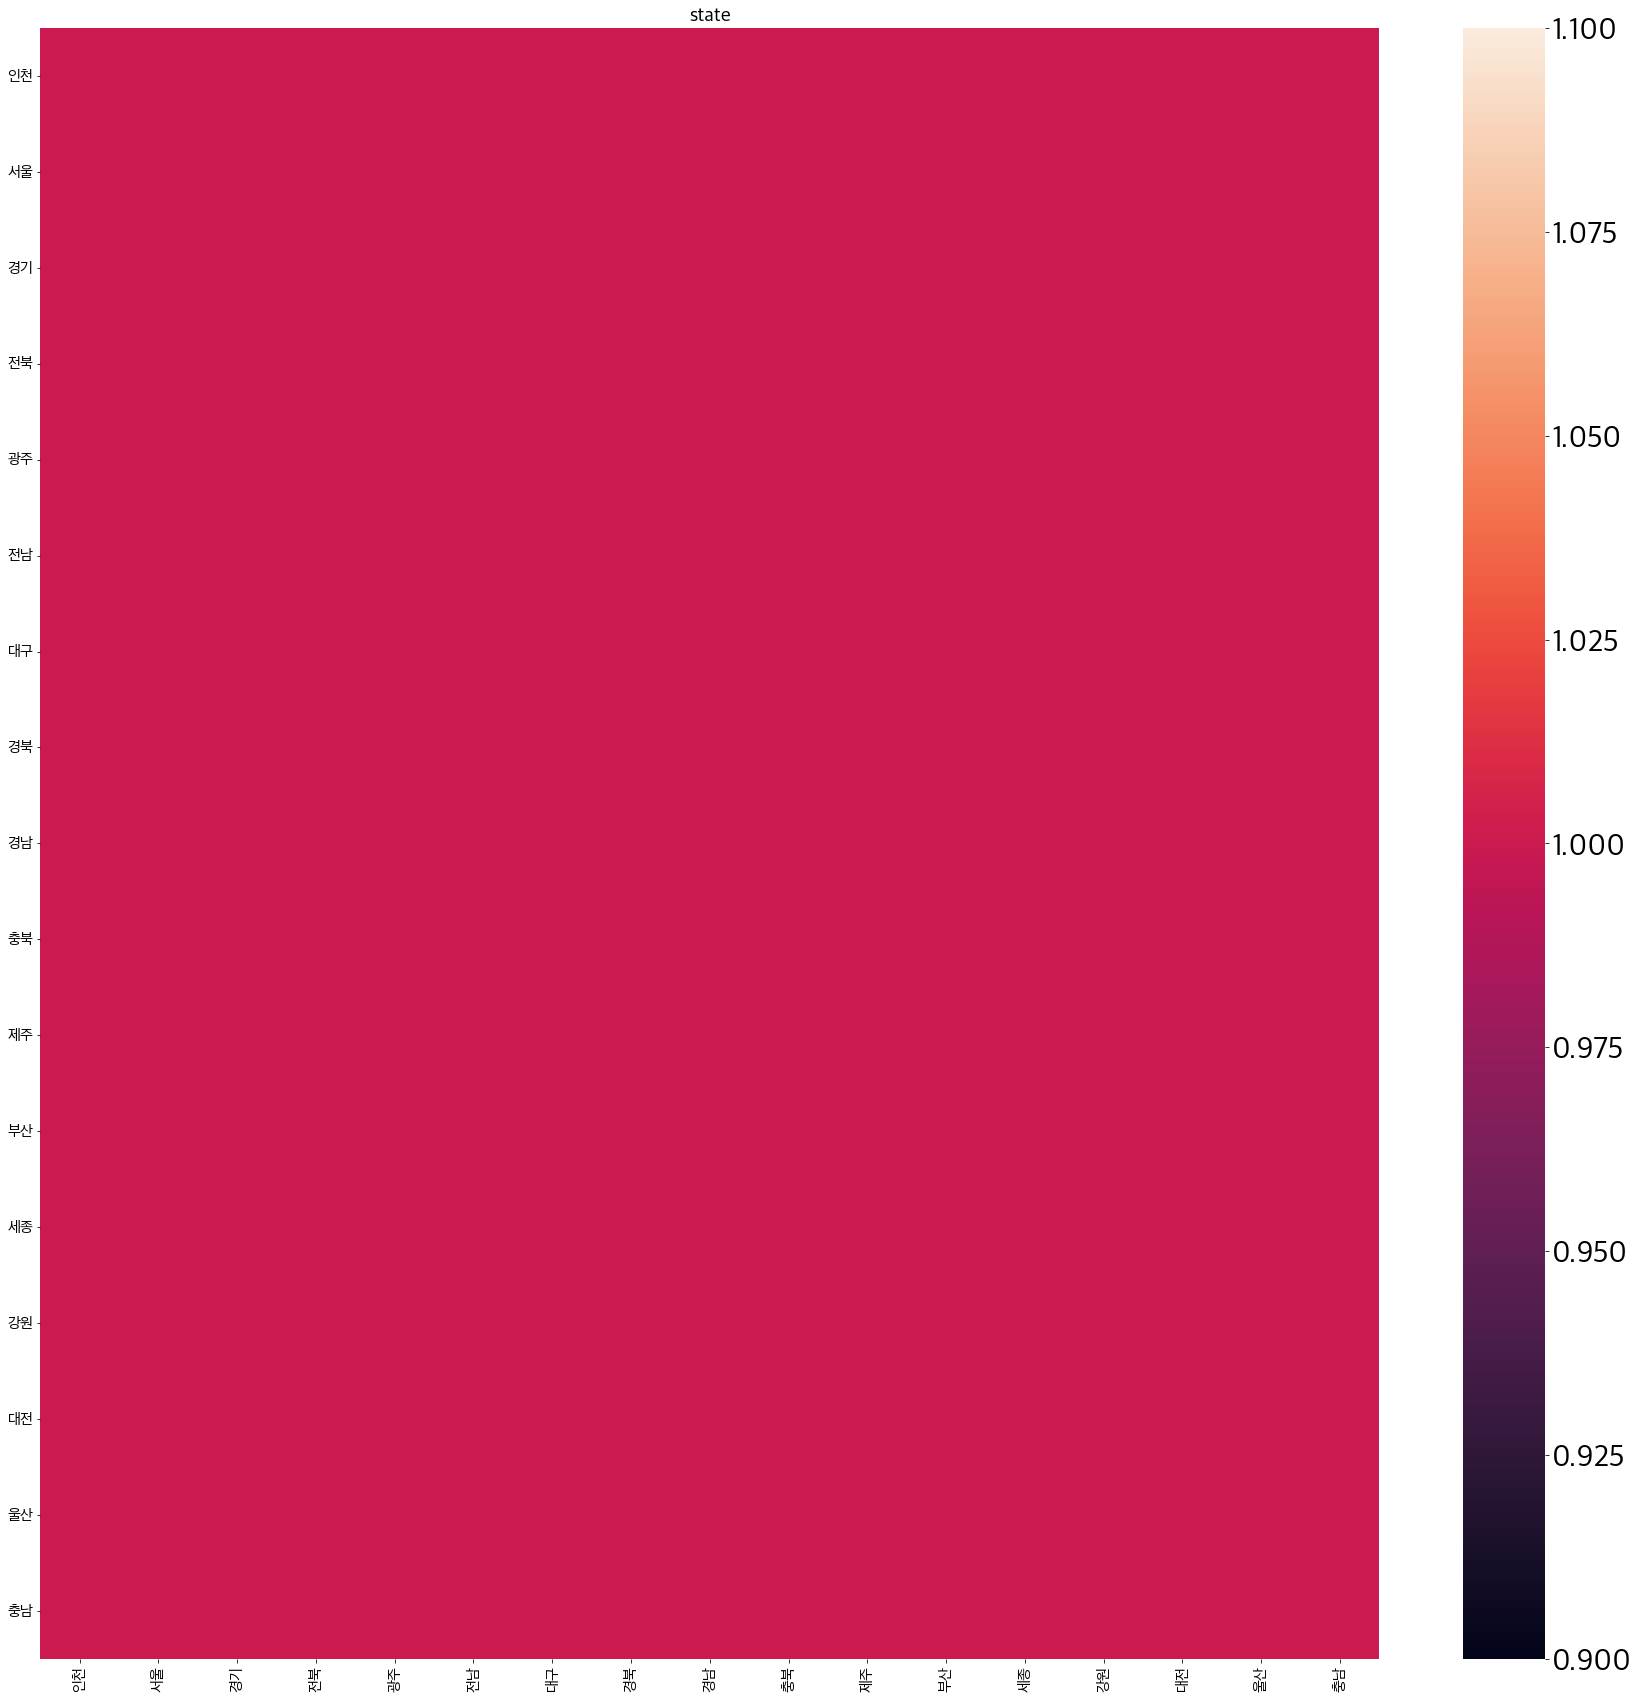

In [5]:
from stgraph_trainer.datasets import Data2Graph
import pandas as pd
# region_type = 'state'
# graph_type = f'dist_01_{region_type}'
dist_mx = pd.read_csv(f'data/distances_kr_{region_type}_adj_mx.csv', encoding='cp949', index_col=0)
norm = 0
data2network = Data2Graph(distance_matrix = dist_mx, temporal_data = df)
G, adj_mx, graph_type = data2network.make_network(network_type='complete',
                                                    region_type=region_type,
                                                    norm=norm,
                                                    int_adj=False) # 대체로 False가 더 좋았음.

data2network.save_graph_html(enc=region_dict, title=region_type, save_name=f'{graph_type}_{norm}')

# Save name setting
date_split = f"{df.index[1]} ~ {df.index[len(train[0])]} ~ {df.index[len(train[0]) + len(val[0])+TIME_STEPS]} ~ {df.index[-1]}"
suptitle_ = f"{MODEL_NAME}_{graph_type}_{norm}_NAdam_adj_intint"
save_path = 'stgnnmodel.pt'

# Save Graph Diameter
import networkx as nx
G1 = G.to_networkx()
pd.DataFrame({'degree' : nx.degree_centrality(G1).values(),
              'eigenvector' : nx.eigenvector_centrality(nx.Graph(G1), max_iter=300).values(),
            #   'katz' : nx.katz_centrality(nx.Graph(G1), max_iter=3000).values(),
              'closeness' : nx.closeness_centrality(nx.Graph(G1)).values(),
              'betweness' : nx.betweenness_centrality(nx.Graph(G1)).values(),
              'clustering_coeff' : nx.clustering(nx.Graph(G1)).values()},
             index= dist_mx.index
             ).to_csv(f"Result/summary/{MODEL_NAME}_{graph_type}_{norm}_diameter.csv"
                 ,encoding='cp949')
             
# Symmmetric Check : False -> Symmetric
False in (adj_mx.numpy() == adj_mx.numpy().transpose())

## Train the model

In [6]:
model = ProposedSTGNN(n_nodes=adj_mx.shape[0],
                      time_steps=TIME_STEPS,
                      predicted_time_steps=1,
                      in_channels=X_train.shape[3],
                      spatial_channels=32,
                      spatial_hidden_channels=16,
                      spatial_out_channels=16,
                      out_channels=16,
                      temporal_kernel=3,
                      drop_rate=0.2).to(device=device)

In [7]:

loss_func = torch.nn.MSELoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

trainer = ProposedSTGNNTrainer(model=model,
                               train_loader=train_dl,
                               val_loader=val_dl,
                            #    test_dl,
                               test_loader=X_test,
                               adj=adj_mx,
                               scaler=scaler,
                               loss=loss_func,
                               optimizer=optimizer,
                               device=device,
                               save_path=save_path,
                               callbacks=None,
                               raw_test=df.iloc[-(n_test_samples + 1):].values)

history = trainer.train(EPOCHS)
# history

/Users/jeonjunhwi/문서/Projects/Master_GNN/Code/stgraph_trainer/models/stgnn.py:356: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float32) # (batch_size, n_nodes, time_steps, in_feautures)


6.69869912188986 stgnnmodel.pt
Epoch: 1; Elapsed time: 0.15053486824035645; Train loss: 3.070286; Val MSE: 6.698699; Val loss RMSE: 2.588185
4.69370464656664 stgnnmodel.pt
Epoch: 2; Elapsed time: 0.1004951000213623; Train loss: 1.264649; Val MSE: 4.693705; Val loss RMSE: 2.166496
4.3511117437611455 stgnnmodel.pt
Epoch: 3; Elapsed time: 0.09862089157104492; Train loss: 1.026667; Val MSE: 4.351112; Val loss RMSE: 2.085932
4.117489317189092 stgnnmodel.pt
Epoch: 4; Elapsed time: 0.0922996997833252; Train loss: 0.931746; Val MSE: 4.117489; Val loss RMSE: 2.029160
3.9628532658452573 stgnnmodel.pt
Epoch: 5; Elapsed time: 0.09705710411071777; Train loss: 0.861867; Val MSE: 3.962853; Val loss RMSE: 1.990692
3.78692801102348 stgnnmodel.pt
Epoch: 6; Elapsed time: 0.16147708892822266; Train loss: 0.793373; Val MSE: 3.786928; Val loss RMSE: 1.946003
3.602742982947308 stgnnmodel.pt
Epoch: 7; Elapsed time: 0.09955286979675293; Train loss: 0.775316; Val MSE: 3.602743; Val loss RMSE: 1.898089
3.5797434

## Prediction

In [8]:
y_pred= trainer.predict(shape=df.shape[1])
y_pred.shape

torch.Size([17, 17, 1])


(17, 17)

In [10]:
df2 = pd.DataFrame(y_pred,
             columns=df.columns,
             index=df.iloc[-n_test_samples:].index)
df2.to_csv(f'Result/pred/pred_STGNN_{graph_type}_{norm}.csv', encoding='cp949')

# Compute RMSE of test dataset
RMSE, RMSE_total = compute_metrics(df.iloc[-n_test_samples:], y_pred, metric='rmse')
MAE, MAE_total = compute_metrics(df.iloc[-n_test_samples:], y_pred, metric='mae')
MAPE, MAPE_total = compute_metrics(df.iloc[-n_test_samples:], y_pred, metric='mape')

df.iloc[-n_test_samples:].to_csv('Result/pred/ground_truth.csv', encoding='cp949')

2022-09-22 21:12:27.657863: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-22 21:12:27.658601: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


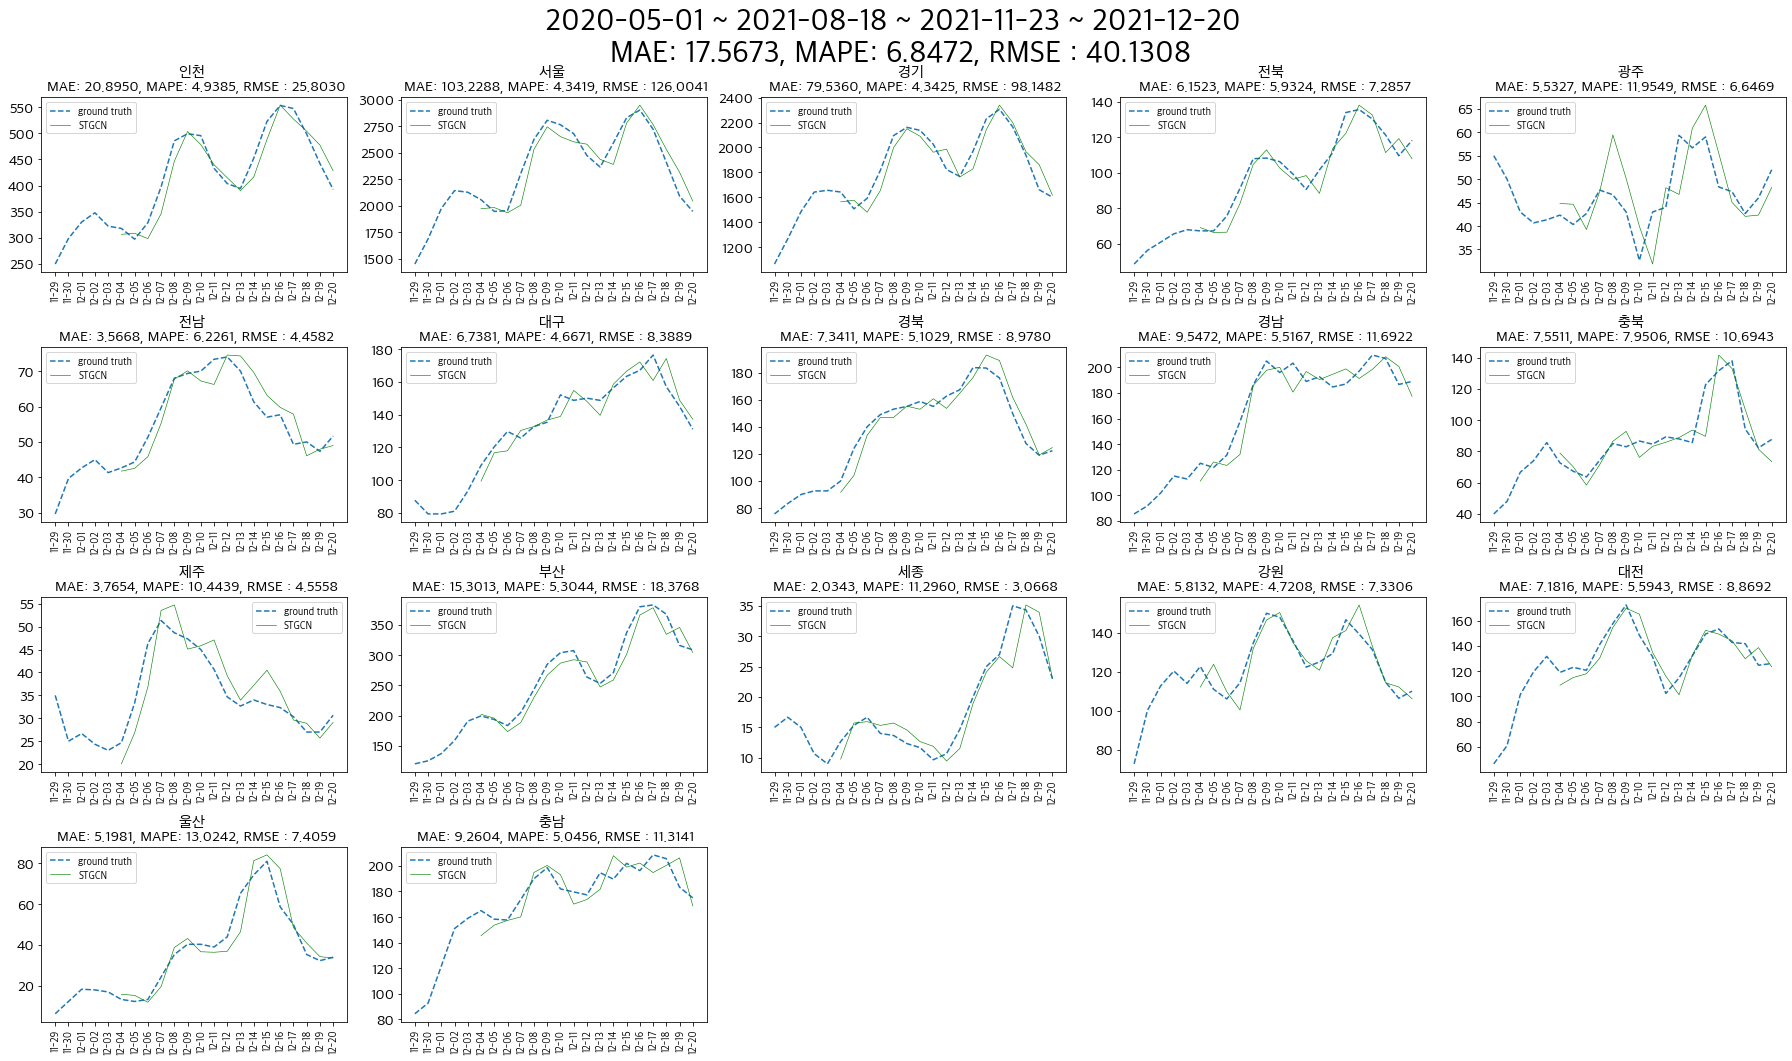

In [11]:
matplotlib_plot_font()
save_figure_predict(df, y_pred,
                    None, None, len(test[0]), TIME_STEPS,
                    region_dict, suptitle_,date_split,
                    MAE, MAPE, RMSE,
                    MAE_total, MAPE_total, RMSE_total, 
                    'Result/')

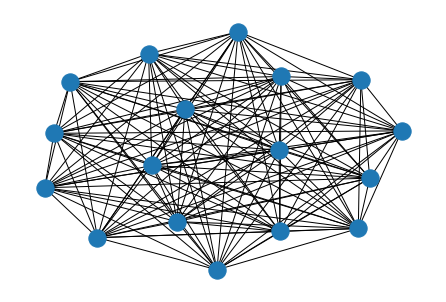

In [12]:
G = nx.complete_graph(17)
nx.draw(G)

In [13]:
tmp = pd.DataFrame(0, columns=[i for i in range(17)], index=[i for i in range(17)])
df = nx.adjacency_data(G)
for i in range(17):
    # self-loop term
    tmp.iloc[i,i] = 1
    for j in df['adjacency'][i]:
        tmp.iloc[i][j['id'][0]] = 1
        tmp.iloc[j['id'][0]][i] = 1
        
# small world network
# how to maching?
        

TypeError: 'int' object is not subscriptable

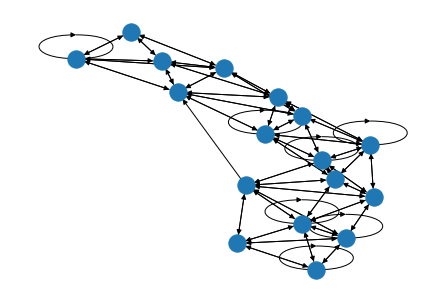

In [ ]:
# p : shortest path length
# q : number of long-range connections for each node
# r : decaying probability of connections
G = nx.navigable_small_world_graph(17, p=3, q=1, r = 2, dim=1)
nx.draw(G)

In [ ]:
tmp = pd.DataFrame(0, columns=[i for i in range(17)], index=[i for i in range(17)])
df = nx.adjacency_data(G)
for i in range(17):
    # self-loop term
    tmp.iloc[i,i] = 1
    for j in df['adjacency'][i]:
        tmp.iloc[i][j['id'][0]] = 1
        tmp.iloc[j['id'][0]][i] = 1
        
# small world network
# how to maching?
        

In [ ]:
tmp
# distance base 로 매칭해야 하는데?
# small world를 어떻게 하지

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0
5,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0
6,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0
7,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0
8,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0
9,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0
